In [1]:
__name__ = "k1lib.callbacks"

In [2]:
#export
from .callbacks import Callback, Callbacks, Cbs
import k1lib, numpy as np, math
import k1lib.cli as cli
from functools import partial
plt = k1lib.dep.plt
from typing import Callable
__all__ = ["Loss", "Accuracy"]

In [15]:
#export
def plotF(losses, f): # actual function stored by the sliceable plot
    plt.figure(figsize=(10, 3), dpi=100); f = f | cli.deref()
    try:
        plt.subplot(1, 2, 1); plt.plot(range(len(losses.train)) | f, losses.train | f); plt.title(f"Train loss")
        plt.subplot(1, 2, 2); plt.plot(range(len(losses.valid)) | f, losses.valid | f); plt.title(f"Valid loss")
    except: pass
def commonPlot(obj, f=cli.iden()):
    plotF(obj, f); return
    return k1lib.viz.SliceablePlot(partial(plotF, obj, f), docs="""\n\nReminder: the actual slice you put in is for the training plot. The valid loss's plot will update automatically to be in the same time frame""")
def nonEmptyList(_list):
    return [0] if _list == [] else _list

In [4]:
#export
@k1lib.patch(Cbs)
class Loss(Callback):
    " "
    def __init__(self, f=lambda l: l.loss):
        """Records losses after each batch.
Expected variables in :class:`~k1lib.Learner`:

- loss: single float value

:param f: optional function to get the loss from :class:`~k1lib.Learner` object"""
        super().__init__(); self.order = 20; self.f = f
        self.train = []; self.valid = [] # all stats all times
        # average stats for each epoch
        self.epoch = k1lib.Object.fromDict({"train": [], "valid": []})\
                        .withRepr("Use...\n" +\
                                 "- `.train` for epoch-averaged training losses\n" +\
                                 "- `.valid` for epoch-averaged validation losses\n" +\
                                 "- `.plot()` to plot the 2 above")
        self.plot = partial(commonPlot, self)
        self.epoch.plot = partial(commonPlot, self.epoch)
        self._trainLosses = []; self._validLosses = []
        self._landscape = k1lib.callbacks.Landscape(lambda l: l.loss, "_LossLandscape")
    def endLoss(self):
        loss = self.f(self.l)
        if self.l.model.training: self._trainLosses.append(loss)
        else: self._validLosses.append(loss)
    def endEpoch(self):
        self.train.extend(self._trainLosses); self.epoch.train.append(np.mean(nonEmptyList(self._trainLosses)))
        self.valid.extend(self._validLosses); self.epoch.valid.append(np.mean(nonEmptyList(self._validLosses)))
        self._trainLosses = []; self._validLosses = []
    @property
    def Landscape(self):
        """Gets loss-landscape-plotting Callback.
Example::

    l = k1lib.Learner.sample()
    l.cbs.add(Cbs.Loss())
    l.Loss.Landscape.plot()"""
        self.cbs.add(self._landscape); return self._landscape
    def detach(self): self._landscape.detach(); return super().detach()
    def clear(self):
        """Clears saved data"""
        self.train = []; self.epoch.train = []
        self.valid = []; self.epoch.valid = []
    def __repr__(self):
        return f"""{super()._reprHead}, use...
- cb.train: for all training losses over all epochs and batches (#epochs * #batches)
- cb.valid: for all validation losses over all epochs and batches (#epochs * #batches)
- cb.plot(): to plot the 2 above
- cb.clear(): to clear saved data
- cb.epoch: for average losses of each epochs
- cb.Landscape: for loss-landscape-plotting Callback
{super()._reprCan}"""

Progress: 100%, epoch:   1/2 (4.77 epochs/s), batch: 299/300 (1.43 k batches/s), elapsed:   0.42s, remaining:  0.0s, loss: 51.87320327758789              

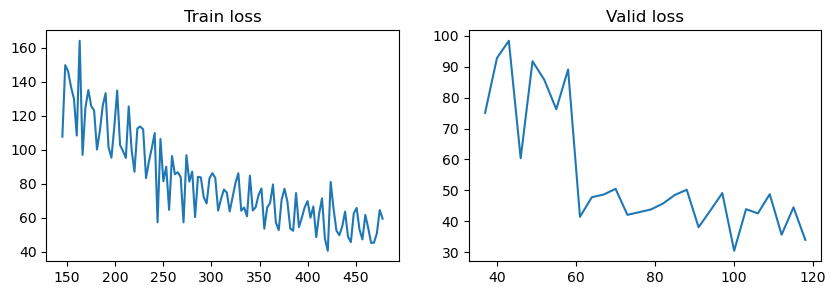

In [19]:
l = k1lib.Learner.sample(); l.cbs.remove("Loss"); l.cbs.add(Loss()); l.run(2);
l.Loss.plot(~cli.head(0.3) | cli.smooth(3) | cli.toList())

Progress: 100%, 1s           8/8 Finished [-2.818, 2.818] range              Run cancelled: Landscape finished.


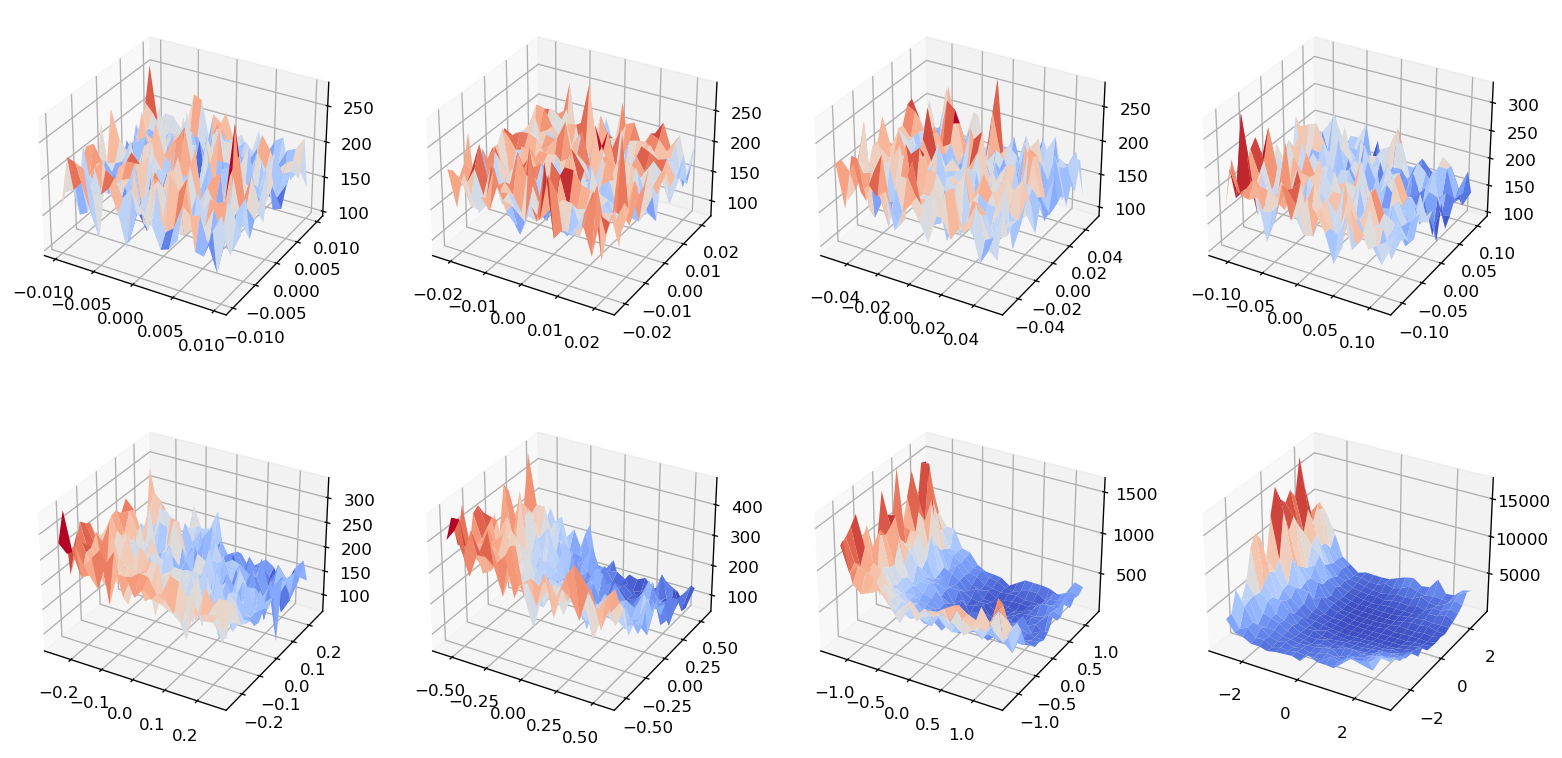

In [6]:
l = k1lib.Learner.sample()
l.cbs.add(Cbs.Loss())
l.Loss.Landscape.plot()

In [6]:
#export
accFMsg = "You have to specify how to compute the accuracy with the AccF callback first"
@k1lib.patch(Cbs)
class Accuracy(Callback):
    " "
    def __init__(self, variable:str="accuracy"):
        """Records accuracies after each batch.
Expected variables in :class:`~k1lib.Learner`:

- accuracy: single float value from 0 to 1

:param variable: name of variable expected to be available in Learner"""
        super().__init__(); self.order = 20
        self.train = [0]; self.valid = [0]; self.paused = True; self.variable = variable
        self._landscape = k1lib.callbacks.Landscape(lambda l: l.__dict__[variable], "_AccuracyLandscape")
    @property
    def hasAccF(self):
        return any(isinstance(cb, Cbs.AccF) for cb in self.l.cbs.cbs)
    def startRun(self):
        self.paused = not self.hasAccF
        if not self.paused:
            self.train = list(self.train); self.valid = list(self.valid)
    def endRun(self):
        if not self.paused:
            self.train = np.array(self.train); self.valid = np.array(self.valid)
    def endLoss(self):
        if not self.paused:
            (self.train if self.l.model.training else self.valid).append(self.l.__dict__[self.variable])
    def plot(self, f=cli.iden()):
        """
:param f:Optional post-processing cli"""
        if not self.hasAccF: raise RuntimeError(accFMsg)
        plt.figure(figsize=(10, 3), dpi=100); f = f | cli.deref()
        try:
            plt.subplot(1, 2, 1); plt.plot(range(len(self.train)) | f, 100*self.train | f); plt.title(f"Train accuracy")
            plt.subplot(1, 2, 2); plt.plot(range(len(self.valid)) | f, 100*self.valid | f); plt.title(f"Valid accuracy")
        except: pass
    @property
    def Landscape(self):
        """Gets accuracy-landscape-plotting Callback.
Example::

    l = k1lib.Learner.sample()
    l.add(Cbs.Accuracy())
    l.Accuracy.Landscape.plot()

This exact example won't work, as the sample :class:`~k1lib.Learner` task is not
categorical, but the general idea still stands"""
        if self.hasAccF:
            self._landscape.parent = self
            self.cbs.add(self._landscape); return self._landscape
        else: raise RuntimeError(f"{accFMsg}, before you can view the landscape")
    def clear(self):
        """Clears saved data."""
        self.train = [0]; self.valid = [0]
    def __repr__(self):
        return f"""{super()._reprHead}{f" (.accuracyF not defined yet)" if not self.hasAccF else ""}, use...
- a.train: for train accuracies over all batches
- a.valid: for train accuracies over all batches
- a.plot(): to plot the 2 above
- a.clear(): to clear saved data
- a.Landscape: for loss-landscape-plotting Callback
{super()._reprCan}"""

In [7]:
try:
    l = k1lib.Learner.sample()
    l.add(Cbs.Accuracy())
    l.Accuracy.Landscape
    assert False
except RuntimeError: pass

In [20]:
!../../export.py callbacks/loss_accuracy

Current dir: /home/kelvin/repos/labs/k1lib, /home/kelvin/repos/labs/k1lib/k1lib/callbacks/../../export.py
rm: cannot remove '__pycache__': No such file or directory
Found existing installation: k1lib 1.2
Uninstalling k1lib-1.2:
  Successfully uninstalled k1lib-1.2
running install
/home/kelvin/anaconda3/envs/torch/lib/python3.9/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/home/kelvin/anaconda3/envs/torch/lib/python3.9/site-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg
running egg_info
creating k1lib.egg-info
writing k1lib.egg-info/PKG-INFO
writing dependency_links to k1lib.egg-info/dependency_links.txt
writing requirements to k1lib.egg-info/requires.txt
writing top-level names to k1lib.egg-info/top_lev